<h1 style="text-align: center">Kaggle KDD BR Competition 2018 finalist solution</h1>
<br>
<p style="text-align: center">
    <a href="https://www.kaggle.com/rafjaa">Rafael Alencar</a>¹, 
    <a href="https://www.kaggle.com/jpmdik">João Paulo de Melo</a>¹, 
    <a href="https://www.kaggle.com/guilhermedomith">Guilherme Domith</a>¹
</p>


<p style="text-align: center">
    ¹ Federal Institute of the Southeast of Minas Gerais, Campus Barbacena
</p>

## Libraries

In [1]:
import datetime

import numpy as np
import pandas as pd

from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

## Model

The small size of the dataset brings as a challenge a great chance of overfitting, and does not make it very suitable for Deep Learning techniques.

Thus, we chose to use the XGBoost model, widely adopted in Kaggle competitions and with a good trade-off between accuracy and training time.

In addition, the model has hyperparameters for overfitting control, such as maximum tree depth and gamma regularization.

In [2]:
from xgboost import XGBRegressor

## Dataset

In [3]:
train = pd.read_csv('./data/train.csv')
train.head()

,Id,field,age,type,harvest_year,harvest_month,production
0,0,0,19,5,2004,1,0.064071
1,1,0,19,5,2004,2,0.047658
2,2,0,19,5,2004,3,0.016866
3,3,0,19,5,2004,4,0.025525
4,4,0,19,5,2004,5,0.047690


In [4]:
test = pd.read_csv('./data/test.csv')
test.head()

,Id,field,age,type,harvest_year,harvest_month
0,5243,0,27,5,2012,1
1,5244,0,27,5,2012,2
2,5245,0,27,5,2012,3
3,5246,0,27,5,2012,4
4,5247,0,27,5,2012,5


## Additional files

We performed some experiments using soil data <code>soil_data.csv</code> and atmospheric data <code>field*.csv</code>, like:

- Feature correlation
- Feature importance
- Sequential feature selection
- Dimensionality reduction

Combinations of these complementary data to training and test set introduced more noise than signal.

Therefore, they were not used.

## Data transformation

Once the use of the XGBoost model was defined, no transformations were applied to the data such scaling (like <code>StandardScaler</code>) or categorical transforms (like <code>OneHotEncoder</code>), since tree-based models do not usually benefit from these techniques.

## Feature selection

We do not use the <code>harvest_year</code> column, since the year values present in the training set are different from those in the test set:

In [5]:
train['harvest_year'].unique()

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

In [6]:
test['harvest_year'].unique()

array([2012, 2013, 2014, 2015, 2016, 2017])

In [7]:
FEATURES =  ['field', 'age', 'type', 'harvest_month']

## Local validation

By the temporal characteristics of the data, we used a validation based on folds segmented by year:

<img src="./data/folds.jpg">

In [8]:
def validation(model, train, features, transform=1):
    scores = []
    
    train['production'] = train['production'] ** transform
    
    for i, year in enumerate(sorted(train['harvest_year'].unique())):
        X_train = train[train['harvest_year'] != year][features].values
        y_train = train[train['harvest_year'] != year]['production'].values
        
        X_test = train[train['harvest_year'] == year][features].values
        y_test = train[train['harvest_year'] == year]['production'].values ** (1 / transform)
        
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
                
        score = metrics.mean_absolute_error(
            y_test,
            pred ** (1 / transform)
        )
        
        scores.append(score)        
        print(year, '-', score)
    
    print('\nMean score:', np.mean(scores))

In [9]:
validation(
    XGBRegressor(random_state=1), 
    train.copy(),
    FEATURES
)

2004 - 0.08249160642854028
2005 - 0.07848157736198758
2006 - 0.07712762225183364
2007 - 0.07531411923053549
2008 - 0.0728327367800164
2009 - 0.08269558166787827
2010 - 0.06935449545319247
2011 - 0.08904272886528519

Mean score: 0.07841755850490867


## Target transformation (production)

The data to be predicted in the regression have a very different probability distribution from the normal distribution, which can impact the accuracy of the model.

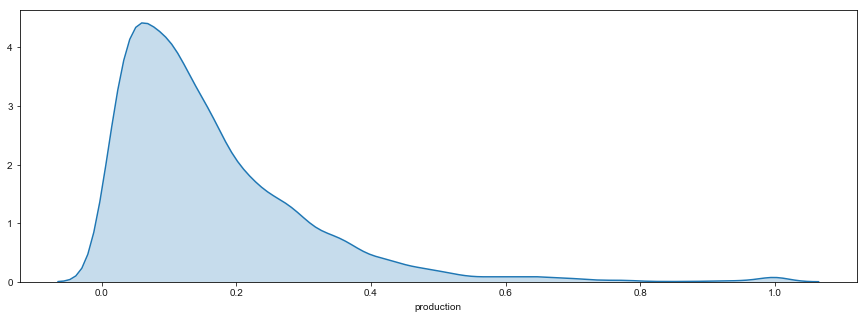

In [10]:
f, ax = plt.subplots(figsize=(15, 5))
sns.set(style='whitegrid')
sns.distplot(train['production'], hist=False, kde_kws={'shade': True});

In this way, we try to apply some transformations in the target, like logarithm and exponentiation.

Empirically we get the exponentiation value 0.1 for best results in local validation and public leaderboard.

In [11]:
validation(
    XGBRegressor(random_state=1), 
    train.copy(), 
    FEATURES,
    transform=0.1
)

2004 - 0.08013765508872801
2005 - 0.07646328994999022
2006 - 0.07674614040385808
2007 - 0.06890207450161724
2008 - 0.07473298182648404
2009 - 0.07974534607549538
2010 - 0.08147277405718546
2011 - 0.08518701471378082

Mean score: 0.0779234095771424


## Harvest years selection

The first two years in training set (2004 and 2005) have production values inconsistent with the others:

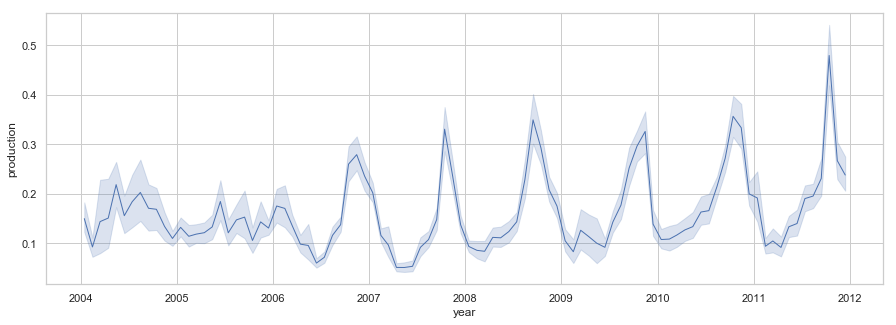

In [12]:
train['year'] = train.apply(
    lambda row: datetime.date(year=int(row['harvest_year']), month=int(row['harvest_month']), day=15), 
    axis=1
).values

f, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='year', y='production', data=train, linewidth=1);

In this way, they were removed from training, to avoid outliers.

In [13]:
train = train[train.harvest_year >= 2006]

In [14]:
validation(
    XGBRegressor(random_state=1), 
    train.copy(), 
    FEATURES,
    transform=0.1
)

2006 - 0.07145274958028677
2007 - 0.06731243211366637
2008 - 0.07323848637402784
2009 - 0.07808036292493216
2010 - 0.0891875156926276
2011 - 0.08582580219257781

Mean score: 0.07751622481301976


In [15]:
train['production'] = train['production'] ** 0.1

## Model 1

XGBRegressor, with <code>max_depth=3</code> to avoid overfitting:

In [16]:
m = XGBRegressor(
    n_jobs=-1, 
    max_depth=3, 
    random_state=1
)

m.fit(
    train[FEATURES],
    train['production']
)

pred_1 = m.predict(test[FEATURES])

## Model 2

XGBRegressor, with <code>gamma=0.1</code>, requiring a minimum loss reduction to make a further partition on a leaf node of the tree, and making the model more conservative.

In [17]:
m = XGBRegressor(
    n_jobs=-1, 
    max_depth=3, 
    gamma=0.1, 
    random_state=1
)

m.fit(
    train[FEATURES],
    train['production']
)

pred_2 = m.predict(test[FEATURES])

##  Average of predictions 

The combination of the predictions of the two models increases the overall score, and acts as an extra help against overfitting.

In [18]:
df_submission = pd.DataFrame()
df_submission['Id'] = test['Id'].values
df_submission['best'] = (pred_1 + pred_2) / 2

df_submission.head()

,Id,best
0,5243,0.764729
1,5244,0.728357
2,5245,0.720708
3,5246,0.720301
4,5247,0.721155


## Dealing unknow types

The test set have two values in the column <code>type</code> that do not appear in the train set: <code>-1</code> and <code>7</code>.

In [19]:
sorted(train.type.unique()), sorted(test.type.unique())

([0, 1, 2, 3, 4, 5, 6], [-1, 0, 1, 2, 3, 4, 5, 6, 7])

In [20]:
set(test.type.unique()) - set(train.type.unique())

{-1, 7}

Because the models did not see these values during training, they will not be able to make an adequate prediction.

Thus, a better estimate for predictions where <code>type</code> is <code>-1</code> or <code>7</code> is to use the average value of production for harvests with similar characteristics:

In [21]:
def mean_predict(row):
    AGE_RANGE = 20

    similar = train[
        (train['field'] == row['field']) & 
        (train['type'] == row['type']) & 
        (train['harvest_month'] == row['harvest_month']) & 
        (train['age'] >= row['age'] - AGE_RANGE) &
        (train['age'] <= row['age'] + AGE_RANGE)
    ]['production']
    
    if similar.shape[0] != 0:
        return similar.mean()
    

    # When row['type'] == 7 or row['type'] == -1
    return train[
            (train['field'] == row['field']) & 
            (train['harvest_month'] == row['harvest_month']) & 
            (train['age'] >= row['age'] - AGE_RANGE) &
            (train['age'] <= row['age'] + AGE_RANGE)
        ]['production'].mean()

We've created a new column with this average prediction:

In [22]:
df_submission['mean'] = test.apply(mean_predict, axis=1)
df_submission.head()

,Id,best,mean
0,5243,0.764729,0.780892
1,5244,0.728357,0.753050
2,5245,0.720708,0.757387
3,5246,0.720301,0.739678
4,5247,0.721155,0.753678


Now we generate the final prediction, using the average value for lines with unknown <code>type</code> values:

In [23]:
df_submission['type'] = test['type'].values

def seleciona(row):
    if row['type'] == -1 or row['type'] == 7:
        return row['mean']
    return row['best']

df_submission['production'] = df_submission.apply(seleciona, axis=1).values

del df_submission['best'], df_submission['mean'], df_submission['type']

df_submission.head()

,Id,production
0,5243,0.764729
1,5244,0.728357
2,5245,0.720708
3,5246,0.720301
4,5247,0.721155


## Inverse target transformation

The <code>production</code> values, previously elevated to <code>0.1</code>, are now transformed back to their original distribution, being raised to <code>1 / 0.1</code>:

In [24]:
df_submission['production'] = df_submission['production'] ** 10
df_submission.head()

,Id,production
0,5243,0.068403
1,5244,0.042019
2,5245,0.037809
3,5246,0.037596
4,5247,0.038044


## Final submission

In [25]:
df_submission.to_csv('submission.csv', index=False)